This code is meant to use pretrained models to extract the features from the parasitized and uninfected cells to aid in improved malaria disease screening. However, you can use these codes as the skeleton to make use of pretrained models as feature extractors for your task of interest.Simply use this skeleton and extract the features from the most optimal layer from the model of your interest for the underlying data. You shall optimize the model hyperparameters to suit your data.

To begin with, let us define a few functions to load the data and convert them to Keras compatible targets. We will load the libraries to begin with.

In [13]:
# load libraries
import cv2
import numpy as np
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt
import itertools
import time
from keras.models import Sequential
from keras.models import Model
from keras import applications
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import log_loss
from sklearn.utils import class_weight
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
%matplotlib inline

We performed 5-fold cross validation at the patient level. we had train and test splits for each fold to ensure that none of the patienet information in the training data leaks into the test data. We randomly split 10% of the training data for validation. For simplicity, we used a single fold here to show how to run the script.

In [14]:
#define data directories
train_data_dir = 'f1_mal/train'
valid_data_dir = 'f1_mal/valid'
test_data_dir = 'f1_mal/test'

# declare the number of samples in each category
nb_train_samples = 17413 #  modify for your dataset
nb_valid_samples = 2176 #  modify for your dataset
nb_test_samples = 2176 # modify for your dataset
num_classes = 2 # binary classification 
img_rows_orig = 128 # modify these values depending on your requirements
img_cols_orig = 128 # modify these values depending on your requirements

Loading Labels

In [15]:
#import pandas as pd

#dataset = pd.read_csv("train_labels.csv")
#dataset.head(10)

#labels = dataset.infected[0 : 17413].tolist()
#labels = list(map(str, labels))
#labels = dataset.infected[17413 : 19589].tolist()
#labels = dataset.infected[19589 : 21765].tolist()

#labels = os.listdir(train_data_dir)
#labels

#or label in labels:
    #image_names_train = os.listdir(os.path.join(train_data_dir))
   # print( image_names_train)

Lets define functions to load and resize the training, validation and test data.

In [16]:
def load_training_data():
    labels = os.listdir(train_data_dir)
    total = len(labels)
    X_train = np.ndarray((nb_train_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_train = np.zeros((nb_train_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_train = os.listdir(os.path.join(train_data_dir, label))
        total = len(image_names_train)
        print(label, total)
        for image_name in image_names_train:
            img = cv2.imread(os.path.join(train_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([img])
            X_train[i] = img
            Y_train[i] = j
            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        j += 1    
    print(i)                
    print('Loading done.')
    print('Transform targets to keras compatible format.')
    Y_train = np_utils.to_categorical(Y_train[:nb_train_samples], num_classes)
    np.save('imgs_train.npy', X_train, Y_train) #save as numpy files
    return X_train, Y_train
    
def load_validation_data():
    # Load validation images
    labels = os.listdir(valid_data_dir)
    X_valid = np.ndarray((nb_valid_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_valid = np.zeros((nb_valid_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating validation images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_valid = os.listdir(os.path.join(valid_data_dir, label))
        total = len(image_names_valid)
        print(label, total)
        for image_name in image_names_valid:
            img = cv2.imread(os.path.join(valid_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([img])
            X_valid[i] = img
            Y_valid[i] = j
            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        j += 1
    print(i)            
    print('Loading done.')
    print('Transform targets to keras compatible format.');
    Y_valid = np_utils.to_categorical(Y_valid[:nb_valid_samples], num_classes)
    np.save('imgs_valid.npy', X_valid, Y_valid) #save as numpy files
    return X_valid, Y_valid

def load_test_data():
    labels = os.listdir(test_data_dir)
    X_test = np.ndarray((nb_test_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_test = np.zeros((nb_test_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_test = os.listdir(os.path.join(test_data_dir, label))
        total = len(image_names_test)
        print(label, total)
        for image_name in image_names_test:
            img = cv2.imread(os.path.join(test_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([img])
            X_test[i] = img
            Y_test[i] = j
            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        j += 1
    print(i)            
    print('Loading done.')
    print('Transform targets to keras compatible format.');
    Y_test = np_utils.to_categorical(Y_test[:nb_test_samples], num_classes)
    np.save('imgs_test.npy', X_test, Y_test) #save as numpy files
    return X_test, Y_test

We will define functions to resize the original images to that dimensions required for the pretrained models using the functions defined below.

In [17]:
def load_resized_training_data(img_rows, img_cols):

    X_train, Y_train = load_training_data()
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:nb_train_samples,:,:,:]])
    
    return X_train, Y_train
    
def load_resized_validation_data(img_rows, img_cols):

    X_valid, Y_valid = load_validation_data()
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:nb_valid_samples,:,:,:]])
        
    return X_valid, Y_valid   

def load_resized_test_data(img_rows, img_cols):

    X_test, Y_test = load_test_data()
    X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:nb_test_samples,:,:,:]])
    
    return X_test, Y_test

An evaluation script has been written to compute the confusion matrix for the performance of the trained model. This function prints and plots the confusion matrix. Normalization can be applied by setting 'normalize=True'.

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We will now proceed to extract the features from our dataset using the pretrained modelsand visualize the confusion matrix, ROC and AUC curves.

In [19]:
img_rows=224 #dimensions of image required for VGG16
img_cols=224
channel = 3 #RGB
num_classes = 2 #binary classification
batch_size = 32 # modify based on the GPUs in your system
num_epoch = 20 # modify depending on the model's convergence with your data

#load data
X_train, Y_train = load_resized_training_data(img_rows, img_cols)
X_valid, Y_valid = load_resized_validation_data(img_rows, img_cols)
X_test, Y_test = load_resized_test_data(img_rows, img_cols)


#print the shape of the data
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)


------------------------------
Creating training images...
------------------------------
0 8793
Done: 0/8793 images
Done: 100/8793 images
Done: 200/8793 images
Done: 300/8793 images
Done: 400/8793 images
Done: 500/8793 images
Done: 600/8793 images
Done: 700/8793 images
Done: 800/8793 images
Done: 900/8793 images
Done: 1000/8793 images
Done: 1100/8793 images
Done: 1200/8793 images
Done: 1300/8793 images
Done: 1400/8793 images
Done: 1500/8793 images
Done: 1600/8793 images
Done: 1700/8793 images
Done: 1800/8793 images
Done: 1900/8793 images
Done: 2000/8793 images
Done: 2100/8793 images
Done: 2200/8793 images
Done: 2300/8793 images
Done: 2400/8793 images
Done: 2500/8793 images
Done: 2600/8793 images
Done: 2700/8793 images
Done: 2800/8793 images
Done: 2900/8793 images
Done: 3000/8793 images
Done: 3100/8793 images
Done: 3200/8793 images
Done: 3300/8793 images
Done: 3400/8793 images
Done: 3500/8793 images
Done: 3600/8793 images
Done: 3700/8793 images
Done: 3800/8793 images
Done: 3900/8793 im

Let us now configure our pretrained model. This code uses VGG16 as a feature extractor and the images are resized to 224 x 224 to support feature extraction.

you can use the rest of the models like:


### ResNet50:

In [ ]:

feature_model = applications.ResNet50((weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) 

feature_model = Model(input=feature_model.input, output=feature_model.get_layer('res5c_branch2c').output) 

#get the model summary
base_model.summary()

### Xception:


In [ ]:

feature_model = applications.Xception((weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
                                      
feature_model = Model(input=feature_model.input, output=feature_model.get_layer('block14_sepconv1').output) 
                                      
#get the model summary
base_model.summary()


### DenseNet121:


For DenseNet, the main file densenet121_model is included to this repository. The model can be used as :

In [7]:

feature_model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)


NameError: name 'densenet121_model' is not defined

### VGG16:

In [36]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, channel))

#extract feature from the optimal layer for your data
base_model = Model(input=base_model.input, output=base_model.get_layer('block5_conv2').output) 

#get the model summary
base_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

c:\users\ankit suman\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  after removing the cwd from sys.path.


Lets modify the architecture by adding a global spatial average pooling layer and a fully-connected layer with a dropout ratio of 0.5 to prevent overfitting and help model generalization. We will train only the top layers which are randomly initialized, freeze all the convolutional layers to prevent large gradient updates wrecking the learned weights. 

In [40]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers to prevent large gradient updates wrecking the learned weights
#for layer in base_model.layers:
    #layer.trainable = False

#fix the optimizer
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) 

#compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


Its time to train the model. We will store only the best model weights by initializing callbacks. Also we can view the performance of our model during run-time by visualizing the performance graphs with Tensorboard. Create a log directory named 'logs' to store the training logs and a separate folder named 'weights' to store the model weights. You can visualize tensorboard graphs simply by navigating to your working directory and do:

$tensorboard --logdir=path/to/log-directory/ --port 6006

Then open localhost:6006 in your browser to view the performance graphs, model architecture and other parameters of your interest.

In [41]:
filepath = 'weights/' + model.name + '.{epoch:02d}-{val_loss:.4f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)

callbacks_list = [checkpoint, tensor_board]


fitting the model.

In [42]:
#compute training time
t=time.time()

results = model.fit(X_train, Y_train, 
                 batch_size = batch_size, 
                 callbacks = callbacks_list,
                 epochs = num_epoch, 
                 verbose=1, 
                 shuffle=True, 
                 validation_data=[X_valid, Y_valid])

#compute the training time
print('Training time: %s' % (time.time()-t))

Train on 17413 samples, validate on 2176 samples
Epoch 1/20
17413/17413 [==============================] - 94s 5ms/step - loss: 0.7271 - acc: 0.4933 - val_loss: 0.6927 - val_acc: 0.5014

Epoch 00001: val_loss improved from inf to 0.69267, saving model to weights/model_7.01-0.6927.h5
Epoch 2/20
17413/17413 [==============================] - 94s 5ms/step - loss: 0.7234 - acc: 0.5000 - val_loss: 0.6920 - val_acc: 0.5014

Epoch 00002: val_loss improved from 0.69267 to 0.69202, saving model to weights/model_7.02-0.6920.h5
Epoch 3/20
17413/17413 [==============================] - 94s 5ms/step - loss: 0.7203 - acc: 0.5036 - val_loss: 0.6914 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.69202 to 0.69141, saving model to weights/model_7.03-0.6914.h5
Epoch 4/20
17413/17413 [==============================] - 94s 5ms/step - loss: 0.7163 - acc: 0.5093 - val_loss: 0.6911 - val_acc: 0.5009

Epoch 00004: val_loss improved from 0.69141 to 0.69114, saving model to weights/model_7.04-0.6911.h5

If you want to visualize the performance of the model in the console other than with Tensorboard, you can use the following script.

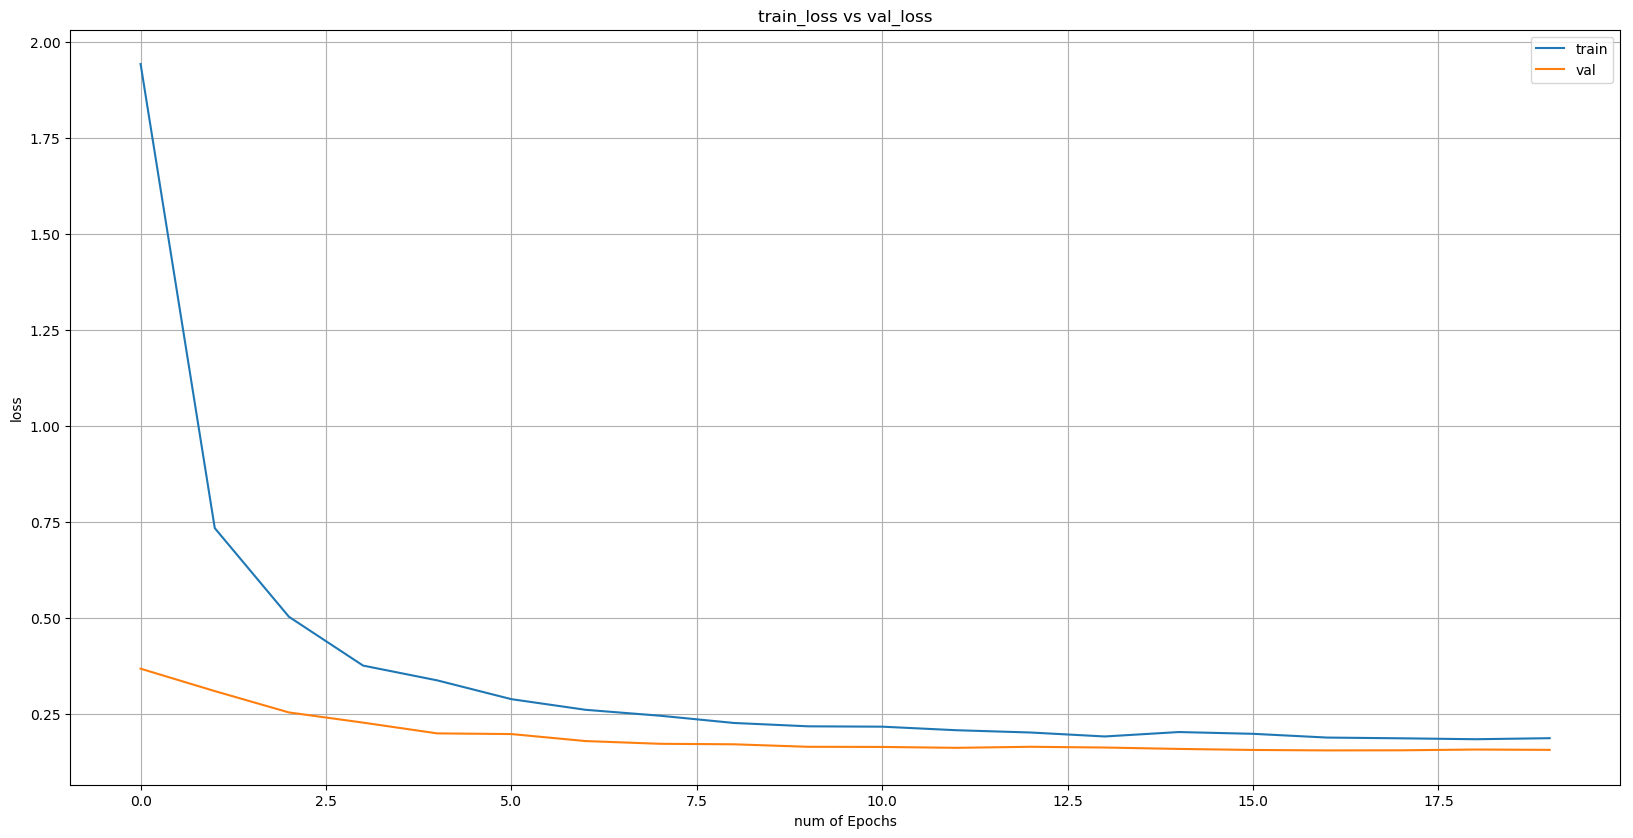

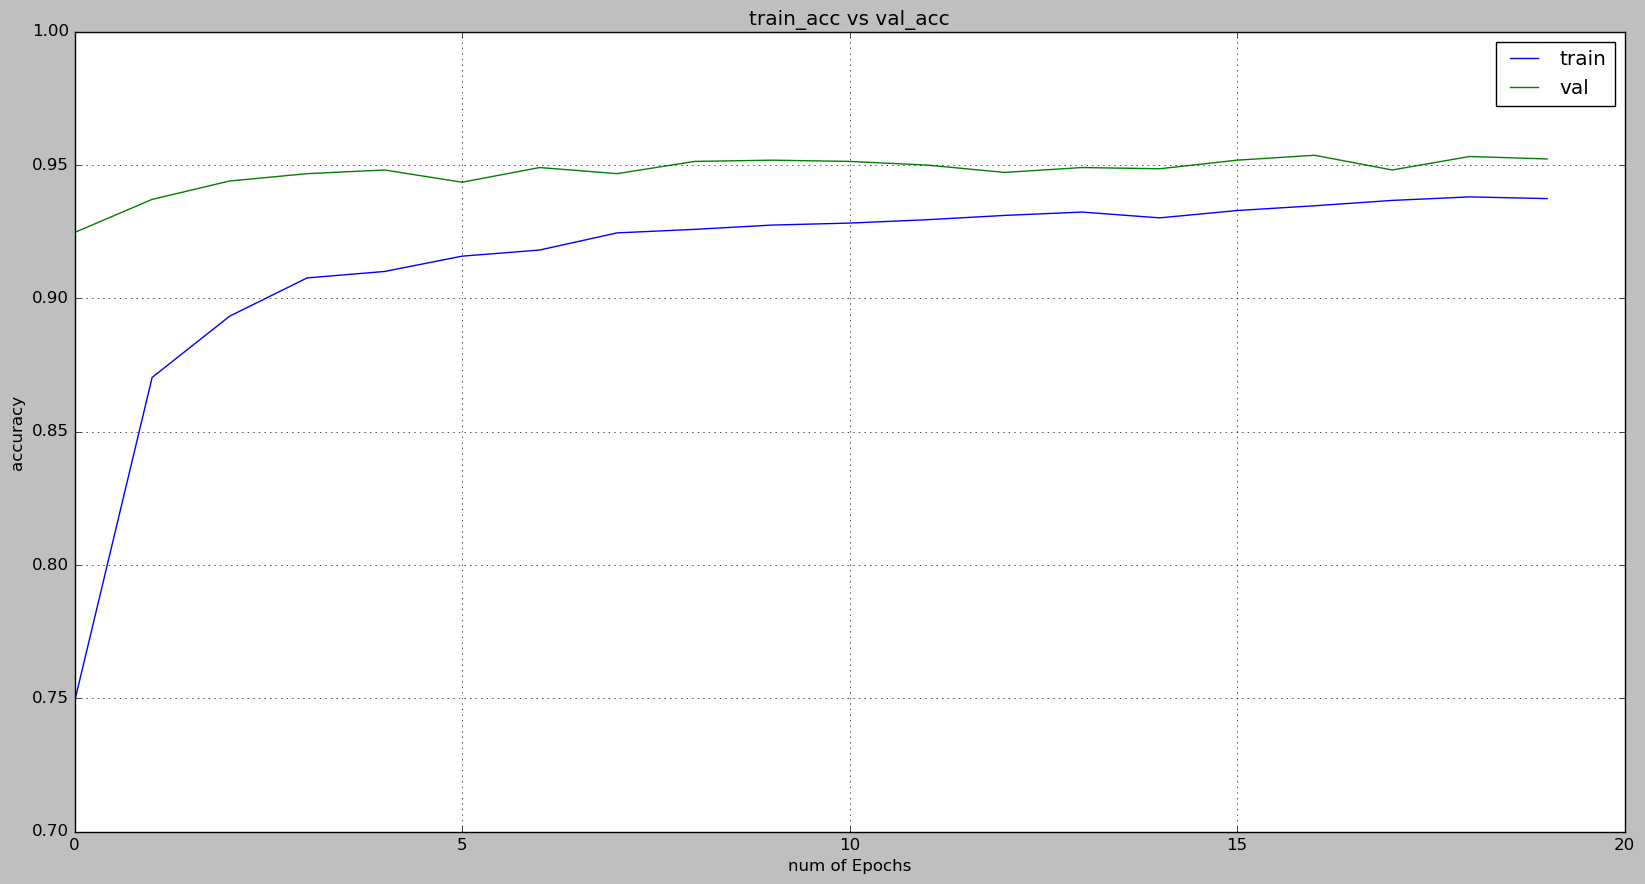

In [27]:
train_loss = results.history['loss']
val_loss =   results.history['val_loss']
train_acc =  results.history['acc']
val_acc =    results.history['val_acc']

xc=range(num_epoch)

plt.figure(1,figsize=(20,10), dpi=100)
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(20,10), dpi=100)
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

Once the model is trained, load the best model weights to predict on the test data.

In [ ]:
model.load_weights('weights/model_2.88-0.1319.h5') #modify for your own model

In [28]:
#predict on the test data
X_test, Y_test = load_resized_test_data(img_rows, img_cols)
print(X_test.shape, Y_test.shape)
print('-'*30)
print('Predicting on the test data...')
print('-'*30)
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

# compute the accuracy
Test_accuracy = accuracy_score(Y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
print("Test_Accuracy = ",Test_accuracy)

------------------------------
Creating test images...
------------------------------
0 1104
Done: 0/1104 images
Done: 100/1104 images
Done: 200/1104 images
Done: 300/1104 images
Done: 400/1104 images
Done: 500/1104 images
Done: 600/1104 images
Done: 700/1104 images
Done: 800/1104 images
Done: 900/1104 images
Done: 1000/1104 images
Done: 1100/1104 images
1 1072
Done: 1200/1072 images
Done: 1300/1072 images
Done: 1400/1072 images
Done: 1500/1072 images
Done: 1600/1072 images
Done: 1700/1072 images
Done: 1800/1072 images
Done: 1900/1072 images
Done: 2000/1072 images
Done: 2100/1072 images
2176
Loading done.
Transform targets to keras compatible format.
(2176, 224, 224, 3) (2176, 2)
------------------------------
Predicting on the test data...
------------------------------
2176/2176 [==============================] - 11s 5ms/step
Test_Accuracy =  0.9586397058823529


Let us now compute the performance metrics for the pretrained VGG16 model with the test data. The performance metrics involve computing the ROC-AUC values, cross-entropy loss score, average precision score, prediction probabilities and storing these values and plotting the ROC curves.

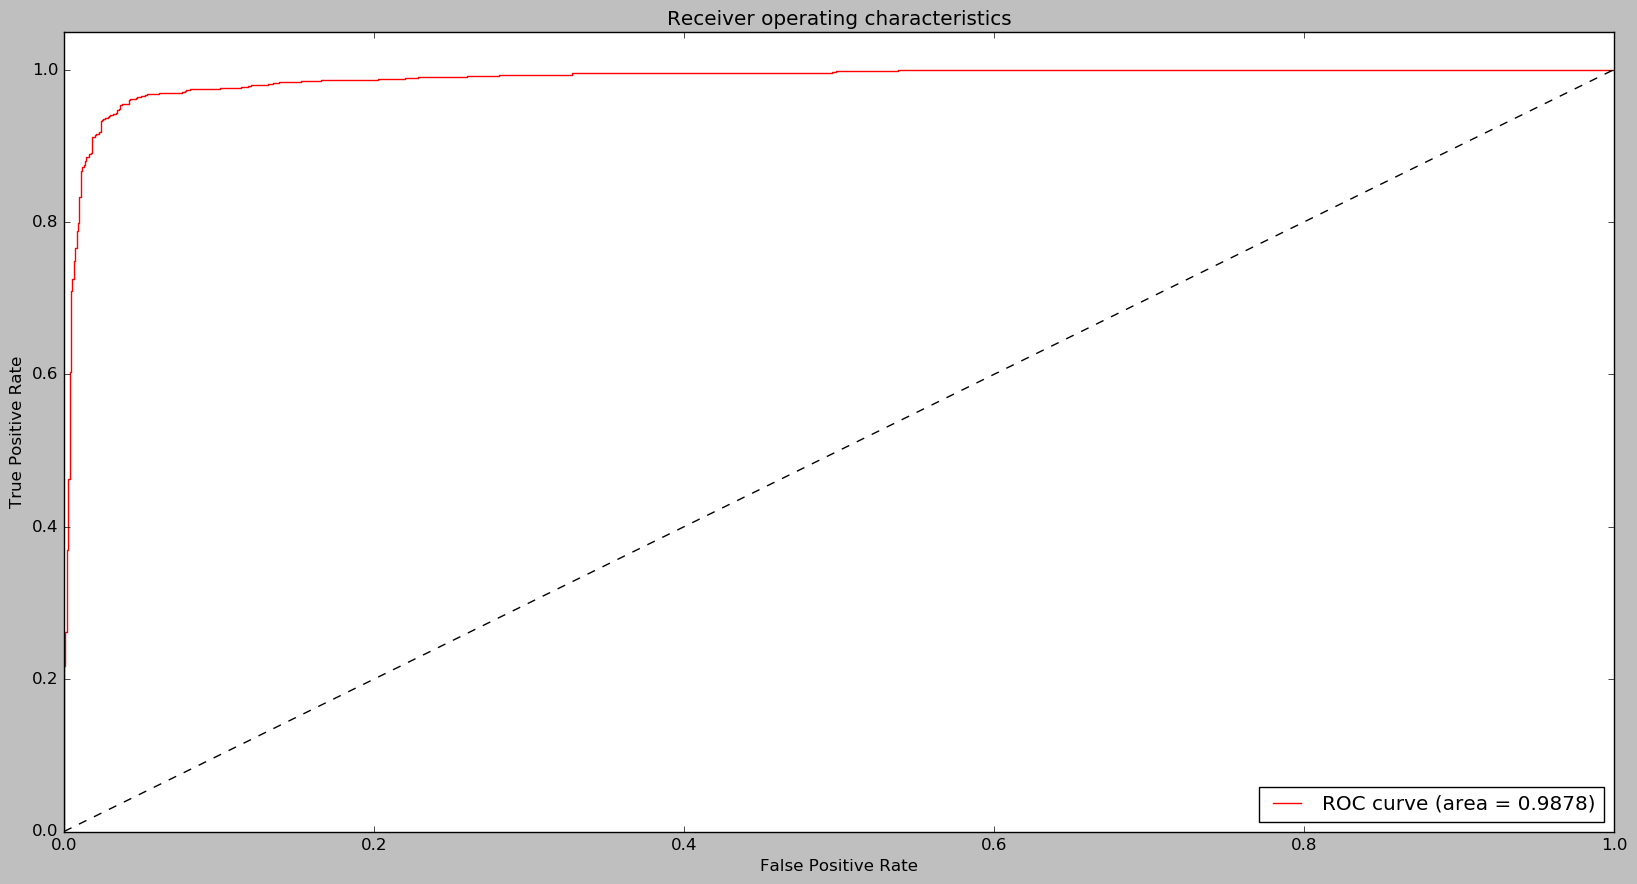

0.1356503289479532
0.9876115596217816
[0 0 0 ... 0 1 1]
[0 0 0 ... 1 1 1]


In [29]:
#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curves
plt.figure(figsize=(20,10), dpi=100)
lw = 1
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

# computhe the cross-entropy loss score
score = log_loss(Y_test,y_pred)
print(score)

# compute the average precision score
prec_score = average_precision_score(Y_test,y_pred)  
print(prec_score)

# transfer it back
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)
print(y_pred)
print(Y_test)

#save the predictions as a CSV file for further analysis
np.savetxt('vgg16_model_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
np.savetxt('vgg16_model_Y_test.csv',Y_test,fmt='%i',delimiter = ",")

Now, let us plot the confusion matrix of the model's performance.

                   precision    recall  f1-score   support

class 0(abnormal)       0.96      0.96      0.96      1104
  class 1(normal)       0.96      0.96      0.96      1072

        micro avg       0.96      0.96      0.96      2176
        macro avg       0.96      0.96      0.96      2176
     weighted avg       0.96      0.96      0.96      2176

[[1057   47]
 [  43 1029]]
Confusion matrix, without normalization
[[1057   47]
 [  43 1029]]


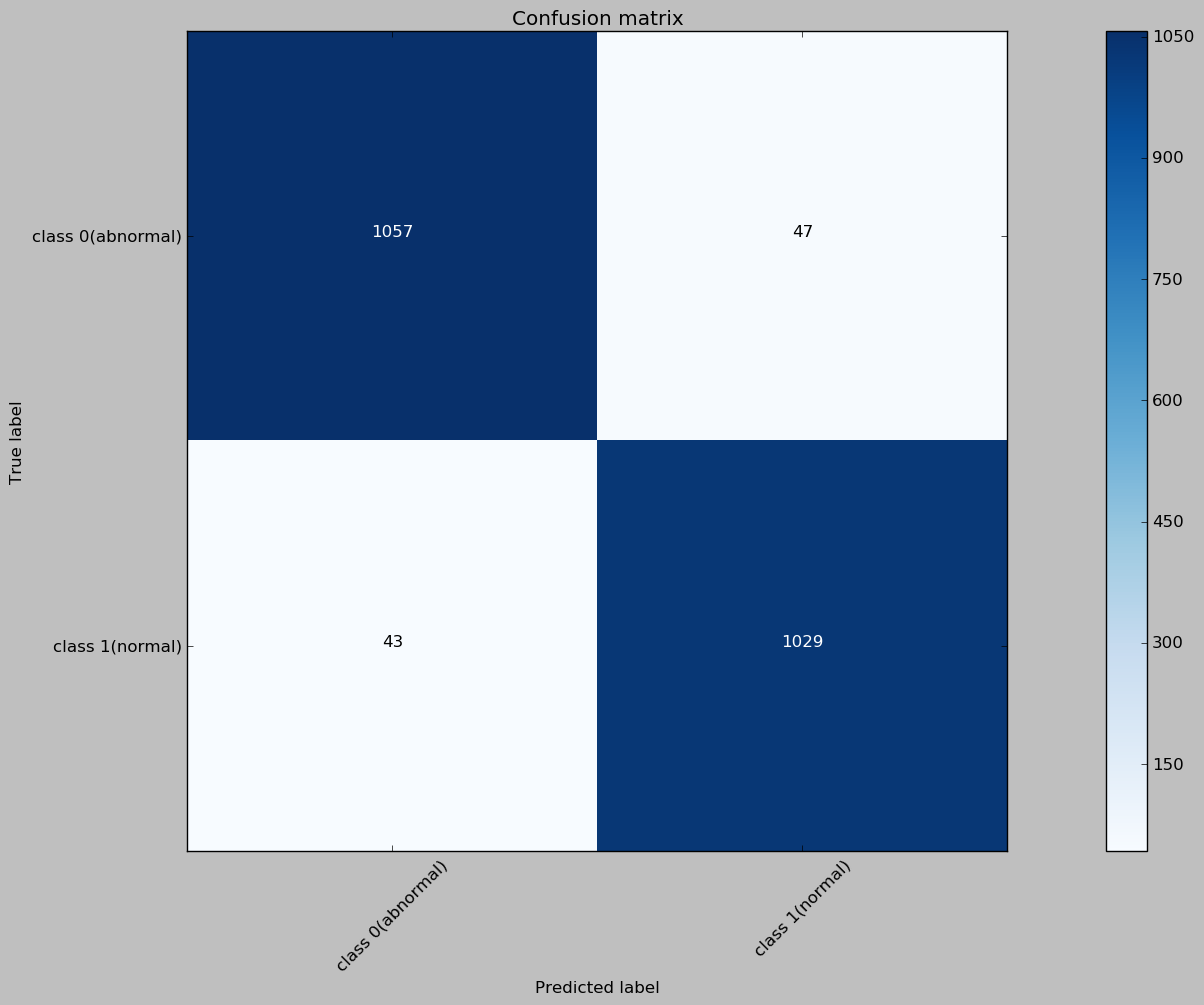

In [30]:
target_names = ['class 0(abnormal)', 'class 1(normal)'] #decide the labels for your own data
print(classification_report(Y_test,y_pred,target_names=target_names))
print(confusion_matrix(Y_test,y_pred))
cnf_matrix = (confusion_matrix(Y_test,y_pred))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                  title='Confusion matrix')
plt.show()

Now writing into the csv, when model see unseen data

In [31]:
from keras.models import load_model
from keras.preprocessing import image
import pandas as pd

testing = pd.read_csv('submission.csv')  

model =load_model('weights/model_2.26-0.1198.h5')


In [34]:
img = image.load_img('test/'+testing.filename[100], target_size=(224,224,3), color_mode="rgb")
img = image.img_to_array(img)
img = img/255

data = np.array([img.reshape( (224, 224, 3) )])

get_data = model.predict(data)
get_data

array([[0.7588, 0.2412]], dtype=float32)

In [35]:
with open('submission_format.csv', 'w') as csvFile:
        csvFile.write('{},{}'.format('filename','infected'))


for i in range(len(testing.filename)):
    
    img = image.load_img('test/'+testing.filename[0], target_size=(224,224,3), color_mode="rgb")
    img = image.img_to_array(img)
    img = img/255
    
    data = np.array([img.reshape( (224, 224, 3) )])
        
    get_data = model.predict(data)
    
    if(get_data[0][0] > get_data[0][1]):
        x = float(0.0)
    else:
        x = float(1.0)

    print('written '+ testing.filename[i])
    
    with open('submission_format.csv', 'a') as csvFile:
        csvFile.write('\n{},{}'.format(testing.filename[i], x))

written 21765.jpg
written 21766.jpg
written 21767.jpg
written 21768.jpg
written 21769.jpg
written 21770.jpg
written 21771.jpg
written 21772.jpg
written 21773.jpg
written 21774.jpg
written 21775.jpg
written 21776.jpg
written 21777.jpg
written 21778.jpg
written 21779.jpg
written 21780.jpg
written 21781.jpg
written 21782.jpg
written 21783.jpg
written 21784.jpg
written 21785.jpg
written 21786.jpg
written 21787.jpg
written 21788.jpg
written 21789.jpg
written 21790.jpg
written 21791.jpg
written 21792.jpg
written 21793.jpg
written 21794.jpg
written 21795.jpg
written 21796.jpg
written 21797.jpg
written 21798.jpg
written 21799.jpg
written 21800.jpg
written 21801.jpg
written 21802.jpg
written 21803.jpg
written 21804.jpg
written 21805.jpg
written 21806.jpg
written 21807.jpg
written 21808.jpg
written 21809.jpg
written 21810.jpg
written 21811.jpg
written 21812.jpg
written 21813.jpg
written 21814.jpg
written 21815.jpg
written 21816.jpg
written 21817.jpg
written 21818.jpg
written 21819.jpg
written 21

written 22230.jpg
written 22231.jpg
written 22232.jpg
written 22233.jpg
written 22234.jpg
written 22235.jpg
written 22236.jpg
written 22237.jpg
written 22238.jpg
written 22239.jpg
written 22240.jpg
written 22241.jpg
written 22242.jpg
written 22243.jpg
written 22244.jpg
written 22245.jpg
written 22246.jpg
written 22247.jpg
written 22248.jpg
written 22249.jpg
written 22250.jpg
written 22251.jpg
written 22252.jpg
written 22253.jpg
written 22254.jpg
written 22255.jpg
written 22256.jpg
written 22257.jpg
written 22258.jpg
written 22259.jpg
written 22260.jpg
written 22261.jpg
written 22262.jpg
written 22263.jpg
written 22264.jpg
written 22265.jpg
written 22266.jpg
written 22267.jpg
written 22268.jpg
written 22269.jpg
written 22270.jpg
written 22271.jpg
written 22272.jpg
written 22273.jpg
written 22274.jpg
written 22275.jpg
written 22276.jpg
written 22277.jpg
written 22278.jpg
written 22279.jpg
written 22280.jpg
written 22281.jpg
written 22282.jpg
written 22283.jpg
written 22284.jpg
written 22

written 22691.jpg
written 22692.jpg
written 22693.jpg
written 22694.jpg
written 22695.jpg
written 22696.jpg
written 22697.jpg
written 22698.jpg
written 22699.jpg
written 22700.jpg
written 22701.jpg
written 22702.jpg
written 22703.jpg
written 22704.jpg
written 22705.jpg
written 22706.jpg
written 22707.jpg
written 22708.jpg
written 22709.jpg
written 22710.jpg
written 22711.jpg
written 22712.jpg
written 22713.jpg
written 22714.jpg
written 22715.jpg
written 22716.jpg
written 22717.jpg
written 22718.jpg
written 22719.jpg
written 22720.jpg
written 22721.jpg
written 22722.jpg
written 22723.jpg
written 22724.jpg
written 22725.jpg
written 22726.jpg
written 22727.jpg
written 22728.jpg
written 22729.jpg
written 22730.jpg
written 22731.jpg
written 22732.jpg
written 22733.jpg
written 22734.jpg
written 22735.jpg
written 22736.jpg
written 22737.jpg
written 22738.jpg
written 22739.jpg
written 22740.jpg
written 22741.jpg
written 22742.jpg
written 22743.jpg
written 22744.jpg
written 22745.jpg
written 22

written 23159.jpg
written 23160.jpg
written 23161.jpg
written 23162.jpg
written 23163.jpg
written 23164.jpg
written 23165.jpg
written 23166.jpg
written 23167.jpg
written 23168.jpg
written 23169.jpg
written 23170.jpg
written 23171.jpg
written 23172.jpg
written 23173.jpg
written 23174.jpg
written 23175.jpg
written 23176.jpg
written 23177.jpg
written 23178.jpg
written 23179.jpg
written 23180.jpg
written 23181.jpg
written 23182.jpg
written 23183.jpg
written 23184.jpg
written 23185.jpg
written 23186.jpg
written 23187.jpg
written 23188.jpg
written 23189.jpg
written 23190.jpg
written 23191.jpg
written 23192.jpg
written 23193.jpg
written 23194.jpg
written 23195.jpg
written 23196.jpg
written 23197.jpg
written 23198.jpg
written 23199.jpg
written 23200.jpg
written 23201.jpg
written 23202.jpg
written 23203.jpg
written 23204.jpg
written 23205.jpg
written 23206.jpg
written 23207.jpg
written 23208.jpg
written 23209.jpg
written 23210.jpg
written 23211.jpg
written 23212.jpg
written 23213.jpg
written 23

written 23617.jpg
written 23618.jpg
written 23619.jpg
written 23620.jpg
written 23621.jpg
written 23622.jpg
written 23623.jpg
written 23624.jpg
written 23625.jpg
written 23626.jpg
written 23627.jpg
written 23628.jpg
written 23629.jpg
written 23630.jpg
written 23631.jpg
written 23632.jpg
written 23633.jpg
written 23634.jpg
written 23635.jpg
written 23636.jpg
written 23637.jpg
written 23638.jpg
written 23639.jpg
written 23640.jpg
written 23641.jpg
written 23642.jpg
written 23643.jpg
written 23644.jpg
written 23645.jpg
written 23646.jpg
written 23647.jpg
written 23648.jpg
written 23649.jpg
written 23650.jpg
written 23651.jpg
written 23652.jpg
written 23653.jpg
written 23654.jpg
written 23655.jpg
written 23656.jpg
written 23657.jpg
written 23658.jpg
written 23659.jpg
written 23660.jpg
written 23661.jpg
written 23662.jpg
written 23663.jpg
written 23664.jpg
written 23665.jpg
written 23666.jpg
written 23667.jpg
written 23668.jpg
written 23669.jpg
written 23670.jpg
written 23671.jpg
written 23

written 24083.jpg
written 24084.jpg
written 24085.jpg
written 24086.jpg
written 24087.jpg
written 24088.jpg
written 24089.jpg
written 24090.jpg
written 24091.jpg
written 24092.jpg
written 24093.jpg
written 24094.jpg
written 24095.jpg
written 24096.jpg
written 24097.jpg
written 24098.jpg
written 24099.jpg
written 24100.jpg
written 24101.jpg
written 24102.jpg
written 24103.jpg
written 24104.jpg
written 24105.jpg
written 24106.jpg
written 24107.jpg
written 24108.jpg
written 24109.jpg
written 24110.jpg
written 24111.jpg
written 24112.jpg
written 24113.jpg
written 24114.jpg
written 24115.jpg
written 24116.jpg
written 24117.jpg
written 24118.jpg
written 24119.jpg
written 24120.jpg
written 24121.jpg
written 24122.jpg
written 24123.jpg
written 24124.jpg
written 24125.jpg
written 24126.jpg
written 24127.jpg
written 24128.jpg
written 24129.jpg
written 24130.jpg
written 24131.jpg
written 24132.jpg
written 24133.jpg
written 24134.jpg
written 24135.jpg
written 24136.jpg
written 24137.jpg
written 24

written 24543.jpg
written 24544.jpg
written 24545.jpg
written 24546.jpg
written 24547.jpg
written 24548.jpg
written 24549.jpg
written 24550.jpg
written 24551.jpg
written 24552.jpg
written 24553.jpg
written 24554.jpg
written 24555.jpg
written 24556.jpg
written 24557.jpg
written 24558.jpg
written 24559.jpg
written 24560.jpg
written 24561.jpg
written 24562.jpg
written 24563.jpg
written 24564.jpg
written 24565.jpg
written 24566.jpg
written 24567.jpg
written 24568.jpg
written 24569.jpg
written 24570.jpg
written 24571.jpg
written 24572.jpg
written 24573.jpg
written 24574.jpg
written 24575.jpg
written 24576.jpg
written 24577.jpg
written 24578.jpg
written 24579.jpg
written 24580.jpg
written 24581.jpg
written 24582.jpg
written 24583.jpg
written 24584.jpg
written 24585.jpg
written 24586.jpg
written 24587.jpg
written 24588.jpg
written 24589.jpg
written 24590.jpg
written 24591.jpg
written 24592.jpg
written 24593.jpg
written 24594.jpg
written 24595.jpg
written 24596.jpg
written 24597.jpg
written 24

written 25003.jpg
written 25004.jpg
written 25005.jpg
written 25006.jpg
written 25007.jpg
written 25008.jpg
written 25009.jpg
written 25010.jpg
written 25011.jpg
written 25012.jpg
written 25013.jpg
written 25014.jpg
written 25015.jpg
written 25016.jpg
written 25017.jpg
written 25018.jpg
written 25019.jpg
written 25020.jpg
written 25021.jpg
written 25022.jpg
written 25023.jpg
written 25024.jpg
written 25025.jpg
written 25026.jpg
written 25027.jpg
written 25028.jpg
written 25029.jpg
written 25030.jpg
written 25031.jpg
written 25032.jpg
written 25033.jpg
written 25034.jpg
written 25035.jpg
written 25036.jpg
written 25037.jpg
written 25038.jpg
written 25039.jpg
written 25040.jpg
written 25041.jpg
written 25042.jpg
written 25043.jpg
written 25044.jpg
written 25045.jpg
written 25046.jpg
written 25047.jpg
written 25048.jpg
written 25049.jpg
written 25050.jpg
written 25051.jpg
written 25052.jpg
written 25053.jpg
written 25054.jpg
written 25055.jpg
written 25056.jpg
written 25057.jpg
written 25

written 25462.jpg
written 25463.jpg
written 25464.jpg
written 25465.jpg
written 25466.jpg
written 25467.jpg
written 25468.jpg
written 25469.jpg
written 25470.jpg
written 25471.jpg
written 25472.jpg
written 25473.jpg
written 25474.jpg
written 25475.jpg
written 25476.jpg
written 25477.jpg
written 25478.jpg
written 25479.jpg
written 25480.jpg
written 25481.jpg
written 25482.jpg
written 25483.jpg
written 25484.jpg
written 25485.jpg
written 25486.jpg
written 25487.jpg
written 25488.jpg
written 25489.jpg
written 25490.jpg
written 25491.jpg
written 25492.jpg
written 25493.jpg
written 25494.jpg
written 25495.jpg
written 25496.jpg
written 25497.jpg
written 25498.jpg
written 25499.jpg
written 25500.jpg
written 25501.jpg
written 25502.jpg
written 25503.jpg
written 25504.jpg
written 25505.jpg
written 25506.jpg
written 25507.jpg
written 25508.jpg
written 25509.jpg
written 25510.jpg
written 25511.jpg
written 25512.jpg
written 25513.jpg
written 25514.jpg
written 25515.jpg
written 25516.jpg
written 25

written 25926.jpg
written 25927.jpg
written 25928.jpg
written 25929.jpg
written 25930.jpg
written 25931.jpg
written 25932.jpg
written 25933.jpg
written 25934.jpg
written 25935.jpg
written 25936.jpg
written 25937.jpg
written 25938.jpg
written 25939.jpg
written 25940.jpg
written 25941.jpg
written 25942.jpg
written 25943.jpg
written 25944.jpg
written 25945.jpg
written 25946.jpg
written 25947.jpg
written 25948.jpg
written 25949.jpg
written 25950.jpg
written 25951.jpg
written 25952.jpg
written 25953.jpg
written 25954.jpg
written 25955.jpg
written 25956.jpg
written 25957.jpg
written 25958.jpg
written 25959.jpg
written 25960.jpg
written 25961.jpg
written 25962.jpg
written 25963.jpg
written 25964.jpg
written 25965.jpg
written 25966.jpg
written 25967.jpg
written 25968.jpg
written 25969.jpg
written 25970.jpg
written 25971.jpg
written 25972.jpg
written 25973.jpg
written 25974.jpg
written 25975.jpg
written 25976.jpg
written 25977.jpg
written 25978.jpg
written 25979.jpg
written 25980.jpg
written 25

written 26389.jpg
written 26390.jpg
written 26391.jpg
written 26392.jpg
written 26393.jpg
written 26394.jpg
written 26395.jpg
written 26396.jpg
written 26397.jpg
written 26398.jpg
written 26399.jpg
written 26400.jpg
written 26401.jpg
written 26402.jpg
written 26403.jpg
written 26404.jpg
written 26405.jpg
written 26406.jpg
written 26407.jpg
written 26408.jpg
written 26409.jpg
written 26410.jpg
written 26411.jpg
written 26412.jpg
written 26413.jpg
written 26414.jpg
written 26415.jpg
written 26416.jpg
written 26417.jpg
written 26418.jpg
written 26419.jpg
written 26420.jpg
written 26421.jpg
written 26422.jpg
written 26423.jpg
written 26424.jpg
written 26425.jpg
written 26426.jpg
written 26427.jpg
written 26428.jpg
written 26429.jpg
written 26430.jpg
written 26431.jpg
written 26432.jpg
written 26433.jpg
written 26434.jpg
written 26435.jpg
written 26436.jpg
written 26437.jpg
written 26438.jpg
written 26439.jpg
written 26440.jpg
written 26441.jpg
written 26442.jpg
written 26443.jpg
written 26

written 26858.jpg
written 26859.jpg
written 26860.jpg
written 26861.jpg
written 26862.jpg
written 26863.jpg
written 26864.jpg
written 26865.jpg
written 26866.jpg
written 26867.jpg
written 26868.jpg
written 26869.jpg
written 26870.jpg
written 26871.jpg
written 26872.jpg
written 26873.jpg
written 26874.jpg
written 26875.jpg
written 26876.jpg
written 26877.jpg
written 26878.jpg
written 26879.jpg
written 26880.jpg
written 26881.jpg
written 26882.jpg
written 26883.jpg
written 26884.jpg
written 26885.jpg
written 26886.jpg
written 26887.jpg
written 26888.jpg
written 26889.jpg
written 26890.jpg
written 26891.jpg
written 26892.jpg
written 26893.jpg
written 26894.jpg
written 26895.jpg
written 26896.jpg
written 26897.jpg
written 26898.jpg
written 26899.jpg
written 26900.jpg
written 26901.jpg
written 26902.jpg
written 26903.jpg
written 26904.jpg
written 26905.jpg
written 26906.jpg
written 26907.jpg
written 26908.jpg
written 26909.jpg
written 26910.jpg
written 26911.jpg
written 26912.jpg
written 26

written 27315.jpg
written 27316.jpg
written 27317.jpg
written 27318.jpg
written 27319.jpg
written 27320.jpg
written 27321.jpg
written 27322.jpg
written 27323.jpg
written 27324.jpg
written 27325.jpg
written 27326.jpg
written 27327.jpg
written 27328.jpg
written 27329.jpg
written 27330.jpg
written 27331.jpg
written 27332.jpg
written 27333.jpg
written 27334.jpg
written 27335.jpg
written 27336.jpg
written 27337.jpg
written 27338.jpg
written 27339.jpg
written 27340.jpg
written 27341.jpg
written 27342.jpg
written 27343.jpg
written 27344.jpg
written 27345.jpg
written 27346.jpg
written 27347.jpg
written 27348.jpg
written 27349.jpg
written 27350.jpg
written 27351.jpg
written 27352.jpg
written 27353.jpg
written 27354.jpg
written 27355.jpg
written 27356.jpg
written 27357.jpg
written 27358.jpg
written 27359.jpg
written 27360.jpg
written 27361.jpg
written 27362.jpg
written 27363.jpg
written 27364.jpg
written 27365.jpg
written 27366.jpg
written 27367.jpg
written 27368.jpg
written 27369.jpg
written 27